<a href="https://colab.research.google.com/github/SambhavShrey/image-caption-genrator-using-cnn/blob/main/image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [ ]:
BASE_DIR = '/content/drive/MyDrive/Colab Notebooks/archive'
WORKING_DIR = '/content/drive/MyDrive/Colab Notebooks/O P'

In [ ]:
model = VGG16()


model = Model(inputs = model.inputs , outputs = model.layers[-2].output)


print(model.summary())

553467096/553467096 [==============================] - 30s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [ ]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):

    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))

    image = img_to_array(image)

    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    image = preprocess_input(image)

    feature = model.predict(image, verbose=0)

    image_id = img_name.split('.')[0]

    features[image_id] = feature

  0%|          | 0/8140 [00:00<?, ?it/s]

In [ ]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [ ]:
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:

mapping = {}

for line in tqdm(captions_doc.split('\n')):

    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]

    image_id = image_id.split('.')[0]

    caption = " ".join(caption)

    if image_id not in mapping:
        mapping[image_id] = []

    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
len(mapping)

8091

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):

            caption = captions[i]

            caption = caption.lower()

            caption = caption.replace('[^A-Za-z]', '')

            caption = caption.replace('\s+', ' ')

            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
clean(mapping)

In [ ]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

40455

In [ ]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

8485

In [ ]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):

    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]

            for caption in captions:

                seq = tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):

                    in_seq, out_seq = seq[:i], seq[i]

                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]


                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

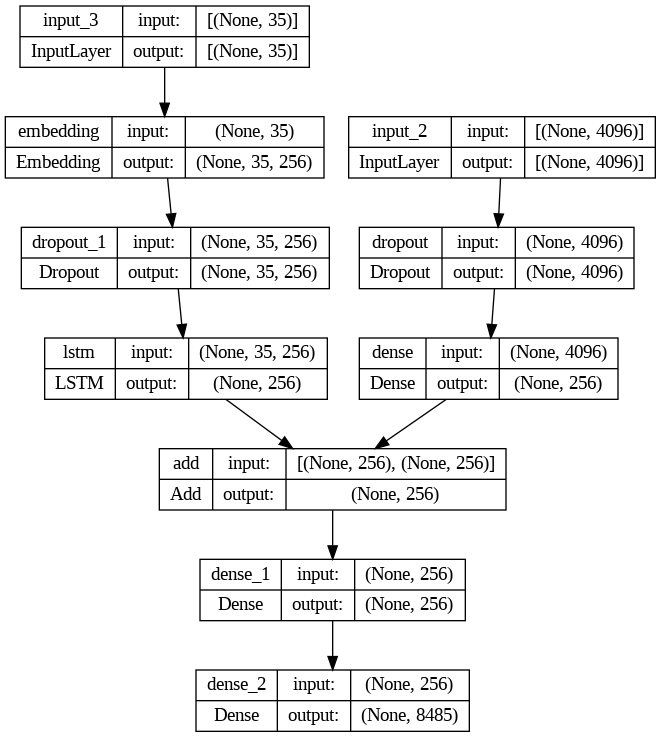

In [ ]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)


decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')


plot_model(model, show_shapes=True)

In [ ]:
epochs = 20
batch_size = 32
steps = len(train)

for i in range(epochs):

    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)

    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

7281/7281 [==============================] - 2037s 280ms/step - loss: 1.4690


In [ ]:
model.save(WORKING_DIR+'/best_model.h5')

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate caption
def predict_caption(model, image, tokenizer, max_length):

    in_text = 'startseq'

    for i in range(max_length):

        sequence = tokenizer.texts_to_sequences([in_text])[0]

        sequence = pad_sequences([sequence], max_length)

        yhat = model.predict([image, sequence], verbose=0)

        yhat = np.argmax(yhat)

        word = idx_to_word(yhat, tokenizer)

        if word is None:
            break

        in_text += " " + word

        if word == 'endseq':
            break

    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate  test data
actual, predicted = list(), list()

for key in tqdm(test):

    captions = mapping[key]

    y_pred = predict_caption(model, features[key], tokenizer, max_length)

    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()

    actual.append(actual_captions)
    predicted.append(y_pred)

  0%|          | 0/810 [00:00<?, ?it/s]

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):

    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)

    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq one man kicks another in the shoulder at martial arts event endseq
startseq two martial artists compete in match endseq
startseq two men are participating in karate match endseq
startseq two men in an oriental fighting contest endseq
startseq two men in karate uniforms kicking each other endseq
--------------------Predicted--------------------
startseq martial artist kicks the head against the other team endseq


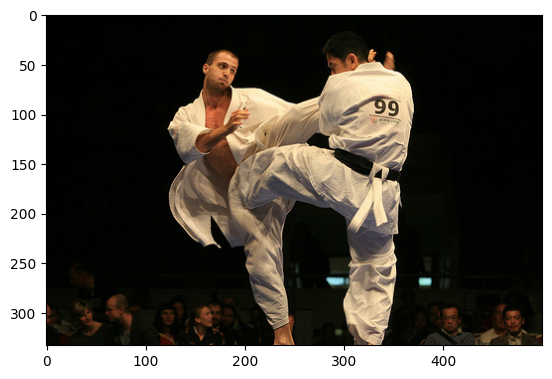

In [ ]:
generate_caption("3727740053_3baa94ffcb.jpg")

---------------------Actual---------------------
startseq boy skateboarding endseq
startseq person does trick with skateboard endseq
startseq skateboarder doing jump endseq
startseq skateboarder performs trick endseq
startseq the guy is wearing blue shirt and doing an ollie endseq
--------------------Predicted--------------------
startseq person doing trick on bike endseq


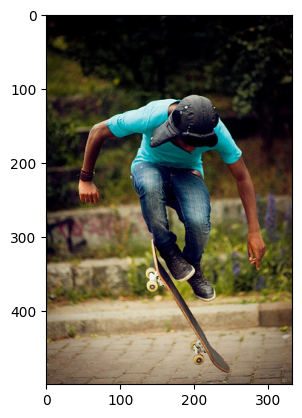

In [ ]:
generate_caption("3668259129_e073af1533.jpg")

---------------------Actual---------------------
startseq dirt biker rounding bend on downhill course endseq
startseq man in white uniform rides motocross bike down forest trail endseq
startseq person on bike and wearing helmet rides through wooded area endseq
startseq "bmx rider riding downhill on forest path ." endseq
startseq the motorbiker is biking on an off road trail endseq
--------------------Predicted--------------------
startseq mountain biking travels over forest trail endseq


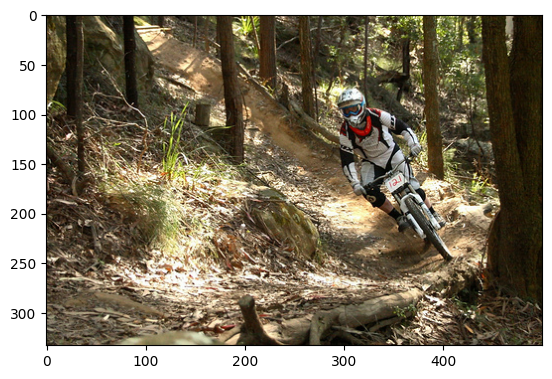

In [ ]:
generate_caption("3667404919_b273df57e4.jpg")

In [ ]:
vgg_model = VGG16()

vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)


In [ ]:
image_path = '/content/drive/MyDrive/Colab Notebooks/archive/Images/1000268201_693b08cb0e.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq girl in blue dress is climbing up wooden swing set endseq'

In [ ]:
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

BLEU-1: 0.495521
BLEU-2: 0.277319
